In [1]:
import pathlib

runs = [
    # ('simplewiki', '20211120', 'en'),
    ('tawiki', '20220301', 'ta'),
    ('fawiki', '20220301', 'fa'),
    ('trwiki', '20220301', 'tr'),
    ('nlwiki', '20220301', 'nl'),
    ('arwiki', '20220301', 'ar'),
    ('srwiki', '20220301', 'sr'),
    ('eswiki', '20220301', 'es'),
    ('jawiki', '20220301', 'ja'),
    ('dewiki', '20220301', 'de'),
]
usefeats = False

import pandas as pd

def ablate(df):
    # Load ablations
    abl = pd.Series(df.index).str.extract(
        'pred-mewsli.'
        '(?P<kind>\w+)'
        '-?(?P<q>q0.25|q0.5|q1)?'
        '(?P<f>.feat-clean-q1\.p[.0-9]+?)?'
        '(?P<b>.\d+b)?'
        '(?P<c>\..*?)?$'
    )
    abl['c'] = abl['c'].fillna('')
    abl['c'] = abl.apply(
        lambda s: (s['c']!='') if s['kind'] not in ['base', 'upper'] else s['c'], axis=1)
    abl['b'] = abl['b'].str[1:-1].astype('float').astype('Int32')
    abl['f'] = abl['f'].fillna('')
    abl['kind'] = abl['kind'].replace('stem', 'clean-stem')


    f1 = df.set_index(pd.MultiIndex.from_frame(abl))[('micro','fscore')].rename('f1')

    f = (f1.index.get_level_values('f')!='') if usefeats else (f1.index.get_level_values('f')=='')
    d = (f1.index.get_level_values('kind')=='base') | (f1.index.get_level_values('kind')=='upper')
    f1 = f1[d | f]
    f1 = f1.droplevel('f')
    return f1

f1s = {}
for wiki, version, langcode in runs:
    fpreds = sorted(pathlib.Path(f'wiki/{wiki}-{version}/experiments/').glob('*.tsv'))
    fgold = pathlib.Path(f'evaluation/Mewsli-9/{langcode}.tsv')


    from minimel import evaluate
    print(langcode)
    df = evaluate(fgold, *fpreds)
    f1s[langcode] = ablate(df)
    

ta


Evaluating: 100%|████████████████████████████████████████████████████| 89/89 [00:02<00:00, 40.09it/s]


fa


Evaluating: 100%|████████████████████████████████████████████████████| 53/53 [00:00<00:00, 90.72it/s]


tr


Evaluating: 100%|████████████████████████████████████████████████████| 53/53 [00:02<00:00, 21.46it/s]


nl


Evaluating: 100%|████████████████████████████████████████████████████| 57/57 [00:05<00:00, 10.22it/s]


ar


Evaluating: 100%|████████████████████████████████████████████████████| 53/53 [00:02<00:00, 19.60it/s]


sr


Evaluating: 100%|████████████████████████████████████████████████████| 53/53 [00:12<00:00,  4.09it/s]


es


Evaluating: 100%|████████████████████████████████████████████████████| 53/53 [00:20<00:00,  2.59it/s]


ja


Evaluating: 100%|████████████████████████████████████████████████████| 53/53 [00:13<00:00,  4.00it/s]


de


Evaluating: 100%|████████████████████████████████████████████████████| 53/53 [00:24<00:00,  2.21it/s]


/tmp/ipykernel_11207/1788748183.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(l)


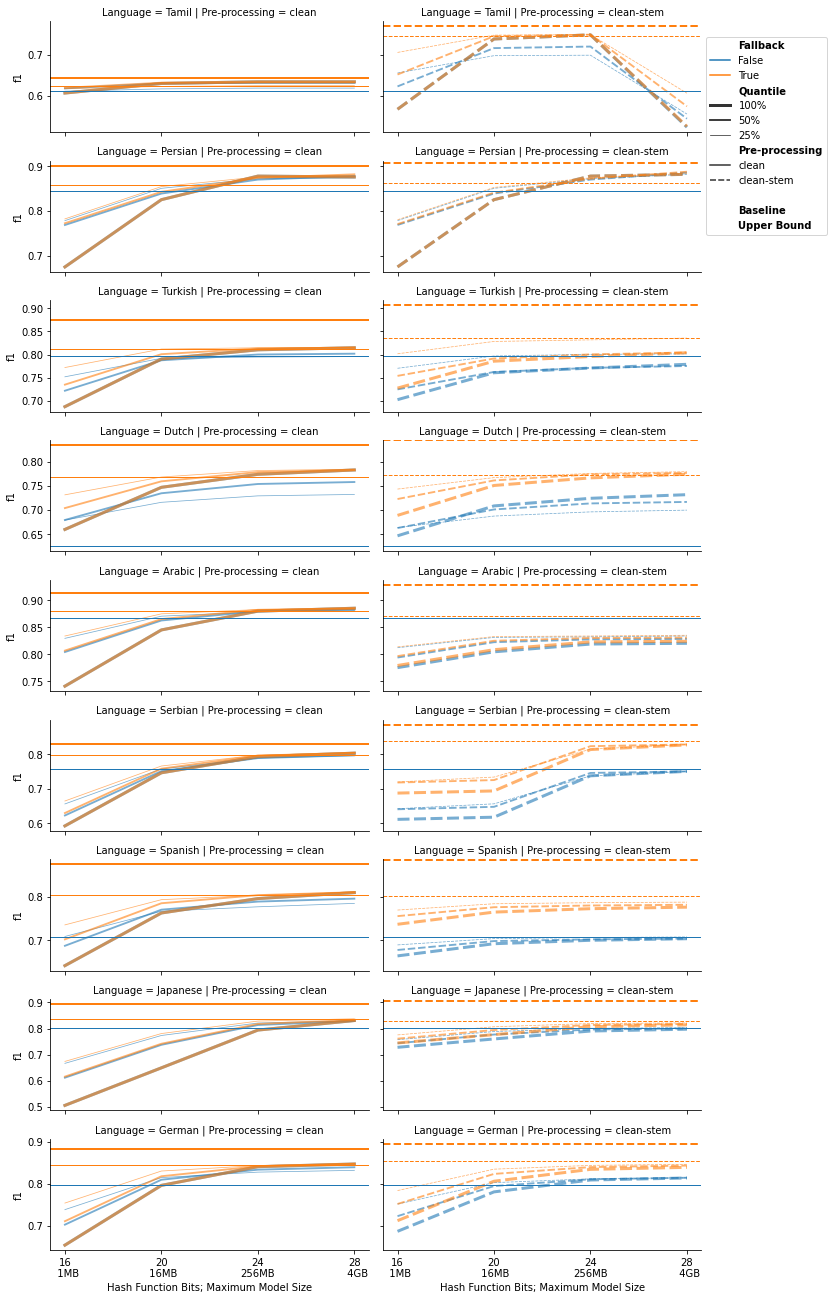

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

BITS = 28

f1 = pd.DataFrame(f1s)
f1.columns.name = 'l'
f1 = f1.stack().rename('f1').reset_index()
data = f1[(~f1['kind'].isin(['base', 'upper'])) & (f1['b'] <= BITS)].rename(columns={
    'c': 'Fallback',
    'q': 'Quantile',
    'b': 'Bits',
    'l': 'Language',
    'kind': 'Pre-processing',
}).sort_values(['Pre-processing','Quantile'], ascending=[1,0])

from minimel import code_name
code_name['fa'] = 'Persian'
code_name['ja'] = 'Japanese'
data['Language'] = data['Language'].map(lambda x: code_name.get(x).title())
data['Quantile'] = data['Quantile'].replace({'q0.25':'25%', 'q0.5':'50%', 'q1':'100%'})

g = sns.relplot(
    kind='line', data=data,
    col='Pre-processing', row='Language',
    x='Bits', y='f1', hue='Fallback', style='Pre-processing', size='Quantile',
    alpha=.6, height=2, aspect=2.5,
    facet_kws={'sharey': 'row'},
)

handles, labels = g._legend.get_lines(), [t.get_text() for t in g._legend.get_texts()]
handles.append( handles[0] ), labels.append('')

handles.append( handles[0] ), labels.append('Baseline')
for (l, bases), axes in zip(f1[f1['kind'] == 'base'].groupby('l', sort=False), list(g.axes)):
    for _, base in bases.iterrows():
        c, basef1 = base.c, base.f1
        ls = '--' if ('stem' in c) else '-'
        color = 'C1' if c else 'C0'
        label = f'base{c[:-3]}'
        for ax in axes:
            if (not c) or (('stem' in c) == ('stem' in ax.get_title())):
                h = ax.axhline(basef1, ls=ls, linewidth=1, color=color, label=label)
        if l == 'en':
            handles.append( h )
            labels.append(label)
            
handles.append( handles[0] ), labels.append('Upper Bound')
for (l, bases), axes in zip(f1[f1['kind'] == 'upper'].groupby('l', sort=False), list(g.axes)):
    for _, base in bases.iterrows():
        c, basef1 = base.c, base.f1
        ls = '--' if ('stem' in c) else '-'
        color = 'C1' if c else 'C0'
        label = f'upper{c[:-3]}'
        for ax in axes:
            if (not c) or (('stem' in c) == ('stem' in ax.get_title())):
                h = ax.axhline(basef1, ls=ls, linewidth=2, color=color, label=label)
        if l == 'en':
            handles.append( h )
            labels.append(label)
            
g._legend.remove()
legend = plt.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1, 10))
for h, text in zip(handles, legend.get_texts()):
    if not h.get_visible():
        text.set_fontweight('bold')
        
# X Axis
def sizeof_fmt(num, suffix="B"):
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if abs(num) < 1024.0:
            return f"{num:3.0f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"
import matplotlib.ticker as ticker
for ax in g.axes.flatten():
    l = [f'{int(x)}\n{sizeof_fmt(2**x*16)}' for x in ax.get_xticks()]
    ax.set_xticklabels(l)
    ax.xaxis.set_major_locator(ticker.FixedLocator([16,20,24, 28]))
    ax.set_xlabel('Hash Function Bits; Maximum Model Size')
    
plt.rcParams['pgf.texsystem'] = 'pdflatex'
plt.savefig(f'paper/fig/super-eval.pgf', bbox_inches='tight')
plt.savefig(f'paper/fig/super-eval.pdf', bbox_inches='tight')

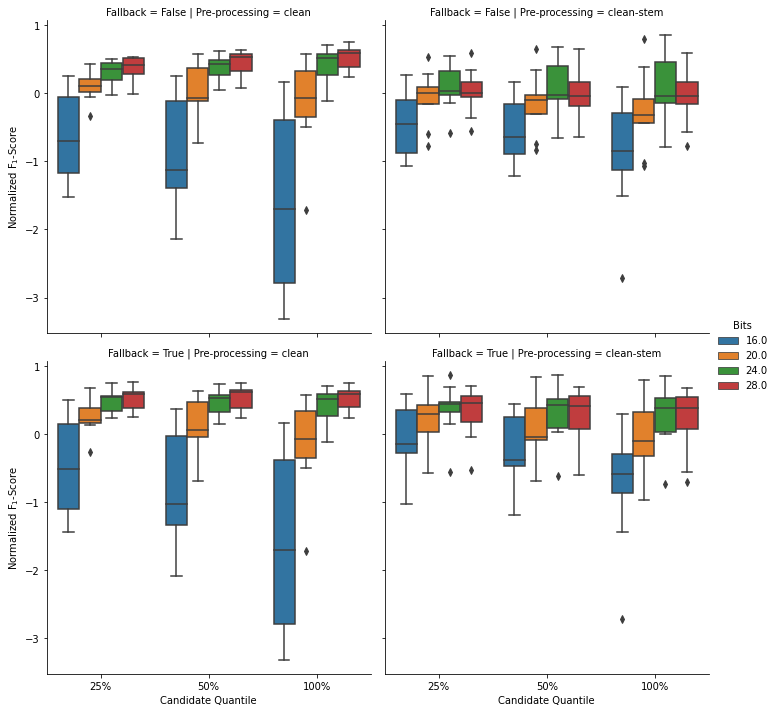

In [3]:
bounds = f1.rename(columns={
    'c': 'Pre-processing',
    'l': 'Language',
})
bounds['Pre-processing'] = bounds['Pre-processing'].str[1:-3]
bounds['Language'] = bounds['Language'].map(lambda x: code_name.get(x).title())
base = (bounds[(bounds['kind'] == 'base') & bounds['Pre-processing']]
        .drop(columns=['kind', 'q', 'b']).set_index(['Language','Pre-processing']))
bottom = (bounds[(bounds['kind'] == 'base') & (bounds['Pre-processing'] == '')]
        .drop(columns=['kind', 'q', 'b', 'Pre-processing']).set_index(['Language']))
upper = bounds[bounds['kind'] == 'upper'].drop(columns=['kind', 'q', 'b']).set_index(['Language','Pre-processing'])

norm = (data.set_index(['Language','Pre-processing', 'Quantile', 'Bits', 'Fallback']) - bottom) / (upper - bottom)
norm = norm.reset_index()
norm.head(50)

g = sns.catplot("Quantile", kind="box", hue="Bits", y="f1", col="Pre-processing", row="Fallback",
    data=norm, order=['25%', '50%', '100%'], facet_kws={'aspect': 3, 'height':1})
g.set_axis_labels("Candidate Quantile", "Normalized F$_1$-Score")

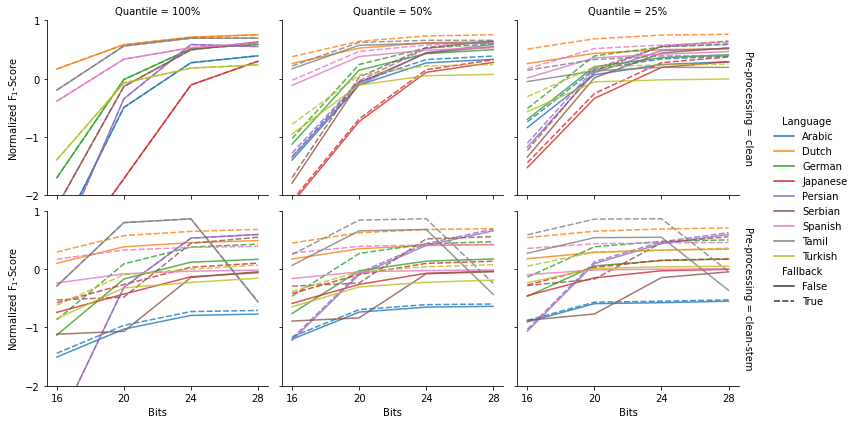

In [4]:
g = sns.relplot(
    kind='line', data=norm,
    row='Pre-processing', col='Quantile',
    x='Bits', y='f1', hue='Language', style='Fallback',
    alpha=.8, height=3, aspect=1.2,
    facet_kws={'margin_titles': True},
)
g.set_axis_labels("Bits", "Normalized F$_1$-Score")
for ax in g.axes.flatten():
    ax.set_ylim([-2, 1])
    ax.yaxis.set_major_locator(ticker.FixedLocator([-2, -1, 0, 1]))
    ax.xaxis.set_major_locator(ticker.FixedLocator([16,20,24, 28]))

plt.rcParams['pgf.texsystem'] = 'pdflatex'
plt.savefig(f'paper/fig/super-eval-norm.pgf', bbox_inches='tight')

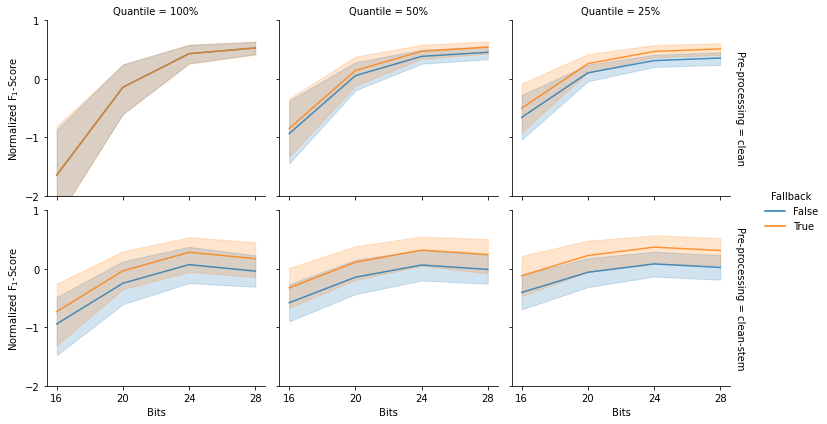

In [5]:
g = sns.relplot(
    kind='line', data=norm,
    row='Pre-processing', col='Quantile',
    x='Bits', y='f1', hue='Fallback',
    alpha=.8, height=3, aspect=1.2,
    facet_kws={'margin_titles': True},
)
g.set_axis_labels("Bits", "Normalized F$_1$-Score")
for ax in g.axes.flatten():
    ax.set_ylim([-2, 1])
    ax.yaxis.set_major_locator(ticker.FixedLocator([-2, -1, 0, 1]))
    ax.xaxis.set_major_locator(ticker.FixedLocator([16,20,24, 28]))

# plt.rcParams['pgf.texsystem'] = 'pdflatex'
# plt.savefig(f'paper/fig/super-eval-norm.pgf', bbox_inches='tight')